<a href="https://colab.research.google.com/github/XuanyouLiu/cis519_project/blob/main/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
!python -m spacy download en_core_web_lg
!pip install gender-guesser
!pip install fuzzywuzzy
!pip install rapidfuzz
!pip install scholarly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [78]:
import os
import pandas as pd
from scholarly import scholarly
import requests
import json
import spacy
from gender_guesser.detector import Detector
import random
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import geopandas as gpd
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
# def fetch_scholars(keyword):
#     search_query = scholarly.search_keyword(keyword)
#     scholars_list = []
#     publications_list = []
#     count = 0

#     for scholar in search_query:

#         try:

#             scholar_filled = scholarly.fill(scholar, sections=['basics', 'indices', 'counts', 'public_access', 'publications'])

#             scholar_data = {
#                 'Name': scholar_filled['name'],
#                 'Affiliation': scholar_filled.get('affiliation', 'N/A'),
#                 'H-index': scholar_filled['hindex'],
#                 'I10-index': scholar_filled['i10index'],
#                 'Total Citations': scholar_filled['citedby'],
#                 'Citations in Last 5 Years': scholar_filled.get('citedby5y', 'N/A'),
#                 'Public Access Paper (Available)': scholar_filled['public_access']['available'],
#                 'Public Access Paper (Not Available)': scholar_filled['public_access']['not_available']
#             }
#             scholars_list.append(scholar_data)
#             print(count+1, end = ":")
#             print(scholar_data)

#             for publication in scholar_filled.get('publications', []):
#                 pub_data = {
#                     'Author Name': scholar_filled['name'],
#                     'Title': publication['bib']['title'],
#                     'Year': publication['bib'].get('pub_year', 'N/A'),
#                     'Citations': publication.get('num_citations', 0)
#                 }
#                 publications_list.append(pub_data)

#             count += 1

#             if count % 100 == 0:
#                 scholars_df = pd.DataFrame(scholars_list)
#                 scholars_df.to_csv(f"/content/drive/My Drive/scholars_data_{count}.csv", index=False)
#                 publication_df = pd.DataFrame(publications_list)
#                 publication_df.to_csv(f"/content/drive/My Drive/publications_data_{count}.csv", index=False)
#                 scholars_list = []
#                 publications_list = []

#         except Exception as e:
#             print(f"Failed to process scholar: {e}")

# keyword = 'human-computer interaction'
# fetch_scholars(keyword)

In [79]:
# Get the list of all CSV files in the scholar folder
csv_files = [os.path.join('/content/drive/My Drive/scholar', filename) for filename in os.listdir('/content/drive/My Drive/scholar') if filename.endswith('.csv')]

# Read each CSV file into a pandas DataFrame
dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]

# Concatenate all the DataFrames into a single DataFrame
scholars = pd.concat(dataframes)

# Drop the "Public Access Paper (Not Available)" and "Public Access Paper (Available)" columns
scholars.drop(columns=["Public Access Paper (Not Available)", "Public Access Paper (Available)"], inplace=True)

# Print the information summary of the dataset
print(scholars.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8800 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Name                       8800 non-null   object
 1   Affiliation                8800 non-null   object
 2   H-index                    8800 non-null   int64 
 3   I10-index                  8800 non-null   int64 
 4   Total Citations            8800 non-null   int64 
 5   Citations in Last 5 Years  8800 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 481.2+ KB
None


In [80]:
# use spacy library to distill the name of organization, and store in title in the "organization" column
nlp = spacy.load("en_core_web_lg")

def extract_organization(text):
    doc = nlp(text)
    orgs = []
    for ent in doc.ents:
        if ent.label_ == "ORG":
            org_text = ent.text
            if "university" or 'college' in org_text.lower():
                return org_text
            # else:
                # orgs.append(org_text)

    if orgs:
        return orgs[0]
    else:
        return None

scholars["organization"] = scholars["Affiliation"].apply(extract_organization)

In [81]:
# predict the gender according to the name colunm, and store the result in the "gender" column. If the library cannot decide, randomly assign
detector = Detector()

def predict_gender(name):

    prediction = detector.get_gender(name)

    if prediction == 'unknown' or 'andy':
        return random.choice(['male', 'female'])
    else:
        return prediction

scholars["gender"] = scholars["Name"].apply(predict_gender)

scholars["gender_encode"] = scholars["gender"].apply(lambda x: 1 if x == "male" else 0)

In [82]:
#inspect "Affliation" column, if there is "prof", write professer in the "title" column. If there is student, write student, if there is researcher write researcher, if there is engineer, write engineer, if there is designer, write designer, if nothing match write nothing

def define_title(affiliation):
  if "associate professor" in affiliation.lower():
    return "Associate Professor"
  if "assistant professor" in affiliation.lower():
    return "Assistant Professor"
  if "prof" in affiliation.lower():
    return "Professor"
  elif "phd" in affiliation.lower():
    return "Student"
  elif "student" in affiliation.lower():
    return "Student"
  elif "scientist" in affiliation.lower():
    return "Scientist"
  elif "researcher" in affiliation.lower():
    return "Researcher"
  elif "engineer" in affiliation.lower():
    return "Engineer"
  elif "designer" in affiliation.lower():
    return "Designer"
  elif "fellow" in affiliation.lower():
    return "Fellow"
  elif "lecturer" in affiliation.lower():
    return "Lecturer"
  elif "faculty" in affiliation.lower():
    return "Lecturer"
  else:
    return None

scholars["title"] = scholars["Affiliation"].apply(define_title)

In [83]:
scholars = scholars.dropna()
scholars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2974 entries, 1 to 95
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Name                       2974 non-null   object
 1   Affiliation                2974 non-null   object
 2   H-index                    2974 non-null   int64 
 3   I10-index                  2974 non-null   int64 
 4   Total Citations            2974 non-null   int64 
 5   Citations in Last 5 Years  2974 non-null   int64 
 6   organization               2974 non-null   object
 7   gender                     2974 non-null   object
 8   gender_encode              2974 non-null   int64 
 9   title                      2974 non-null   object
dtypes: int64(5), object(5)
memory usage: 255.6+ KB


In [84]:
# prompt: encode the title columns according to its content, with more predigious title encode with larger number. if it is none encode with 0

title_encoding = {
  "Professor": 5,
  "Associate Professor": 4,
  "Assistant Professor": 3,
  "Scientist": 2,
  "Researcher": 2,
  "Engineer": 1,
  "Designer": 1,
  "Student": 0.5,
  "Fellow": 0.5,
  "Lecturer": 0.5,
  None: 0
}

scholars["title_encoded"] = scholars["title"].map(title_encoding)


<ipython-input-84-aa6055ee591c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scholars["title_encoded"] = scholars["title"].map(title_encoding)


In [85]:
# Read the QS ranking file into a pandas DataFrame
qs_rankings = pd.read_csv('/content/drive/My Drive/QS ranking.csv')

# Drop all columns except for "2024 RANK" and "Institution Name"
qs_rankings = qs_rankings[["2024 RANK", "Institution Name", "Country"]]

# Rename the "Institution Name" column to "organization" to match the scholars DataFrame
qs_rankings.rename(columns={"Institution Name": "organization"}, inplace=True)

def find_matching_ranking(name):
    matches = process.extractOne(name, qs_rankings['organization'], scorer=fuzz.WRatio)
    if matches[1] >= 70:
        match_row = qs_rankings[qs_rankings['organization'] == matches[0]]
        return match_row["2024 RANK"].values[0], match_row["Country"].values[0]
    return None, None

# 并行处理
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(find_matching_ranking, scholars['organization']))

scholars['ranking'], scholars['country'] = zip(*results)

In [86]:
def clean_ranking(ranking):
    if pd.isnull(ranking):
        return None
    ranking = ranking.replace("=", "").replace("+", "").strip()
    if "-" in ranking:
        ranking = ranking.split("-")[0]
    if ranking.isdigit():
        return int(ranking)
    else:
        return None


scholars["ranking"] = scholars["ranking"].apply(clean_ranking)

max_rank = scholars["ranking"].max()
scholars["ranking"].fillna(max_rank, inplace=True)
scholars["country"] = scholars["country"].fillna("Unknown")

scholars = scholars.dropna()

scholars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2974 entries, 1 to 95
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       2974 non-null   object 
 1   Affiliation                2974 non-null   object 
 2   H-index                    2974 non-null   int64  
 3   I10-index                  2974 non-null   int64  
 4   Total Citations            2974 non-null   int64  
 5   Citations in Last 5 Years  2974 non-null   int64  
 6   organization               2974 non-null   object 
 7   gender                     2974 non-null   object 
 8   gender_encode              2974 non-null   int64  
 9   title                      2974 non-null   object 
 10  title_encoded              2974 non-null   float64
 11  ranking                    2974 non-null   float64
 12  country                    2974 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 325.3+

In [87]:
# Get the list of all CSV files in the publications folder
csv_files = [os.path.join('/content/drive/My Drive/publications', filename) for filename in os.listdir('/content/drive/My Drive/publications') if filename.endswith('.csv')]

# Read each CSV file into a pandas DataFrame
dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]

# Concatenate all the DataFrames into a single DataFrame
publications = pd.concat(dataframes)

publications.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518149 entries, 0 to 709
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Author Name  518149 non-null  object 
 1   Title        518149 non-null  object 
 2   Year         485888 non-null  float64
 3   Citations    518149 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 19.8+ MB


In [88]:
# Calculate the total number of publications for each author
publication_counts = publications.groupby('Author Name').size().reset_index(name='Total Publications')

# Calculate the maximum citation for each author
max_citations = publications.groupby('Author Name')['Citations'].max().reset_index(name='Max Citation')

# Merge the two DataFrames to create a new DataFrame
publication_author = pd.merge(publication_counts, max_citations, on='Author Name')

In [89]:
merged_df = pd.merge(scholars, publication_author, left_on='Name', right_on='Author Name', how='inner')

merged_df.drop(columns=['Author Name'], inplace=True)

scholars = merged_df

<ipython-input-90-3eab9590e948>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


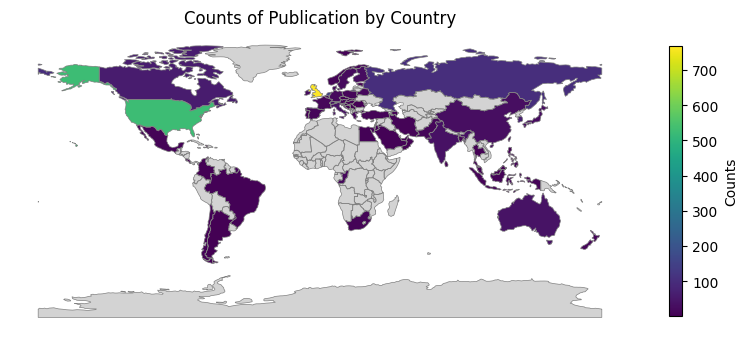

In [90]:
# calculate the time each country appear
scholars_country = scholars.groupby('country').size().reset_index(name='Counts')

# load the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# map the country name to the world map

map_country_to_world = {
    row['country']: process.extractOne(row['country'], world['name'])[0]
    for index, row in scholars_country.iterrows()
}

scholars_country['world_name'] = scholars_country['country'].map(map_country_to_world)

world = world.merge(scholars_country, how="left", left_on="name", right_on="world_name")

# plot the word map
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
world.boundary.plot(ax=ax, linewidth=0.5, color='grey')
world.plot(column='Counts', ax=ax, legend=True,
           legend_kwds={'label': "Counts", 'shrink': 0.7, 'aspect': 20},
           cmap='viridis', missing_kwds={'color': 'lightgrey'})
ax.set_axis_off()
plt.title("Counts of Publication by Country")

plt.show()

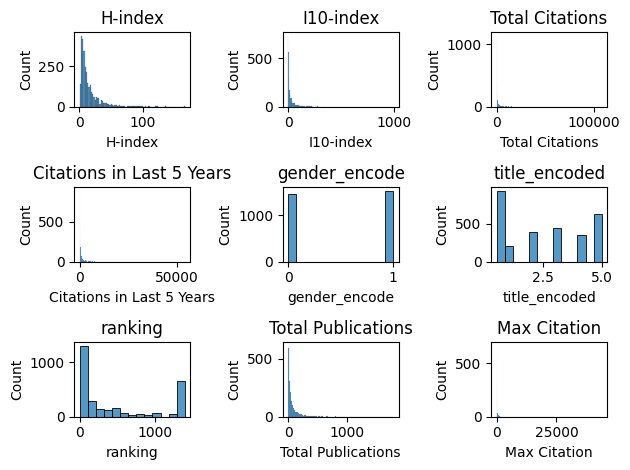

In [91]:
numeric_columns = scholars.select_dtypes(include=["int", "float"]).columns

for i, column in enumerate(numeric_columns):
  plt.subplot(3, 3, i + 1)
  sns.histplot(data=scholars, x=column)
  plt.title(column)
  plt.tight_layout()

plt.show()

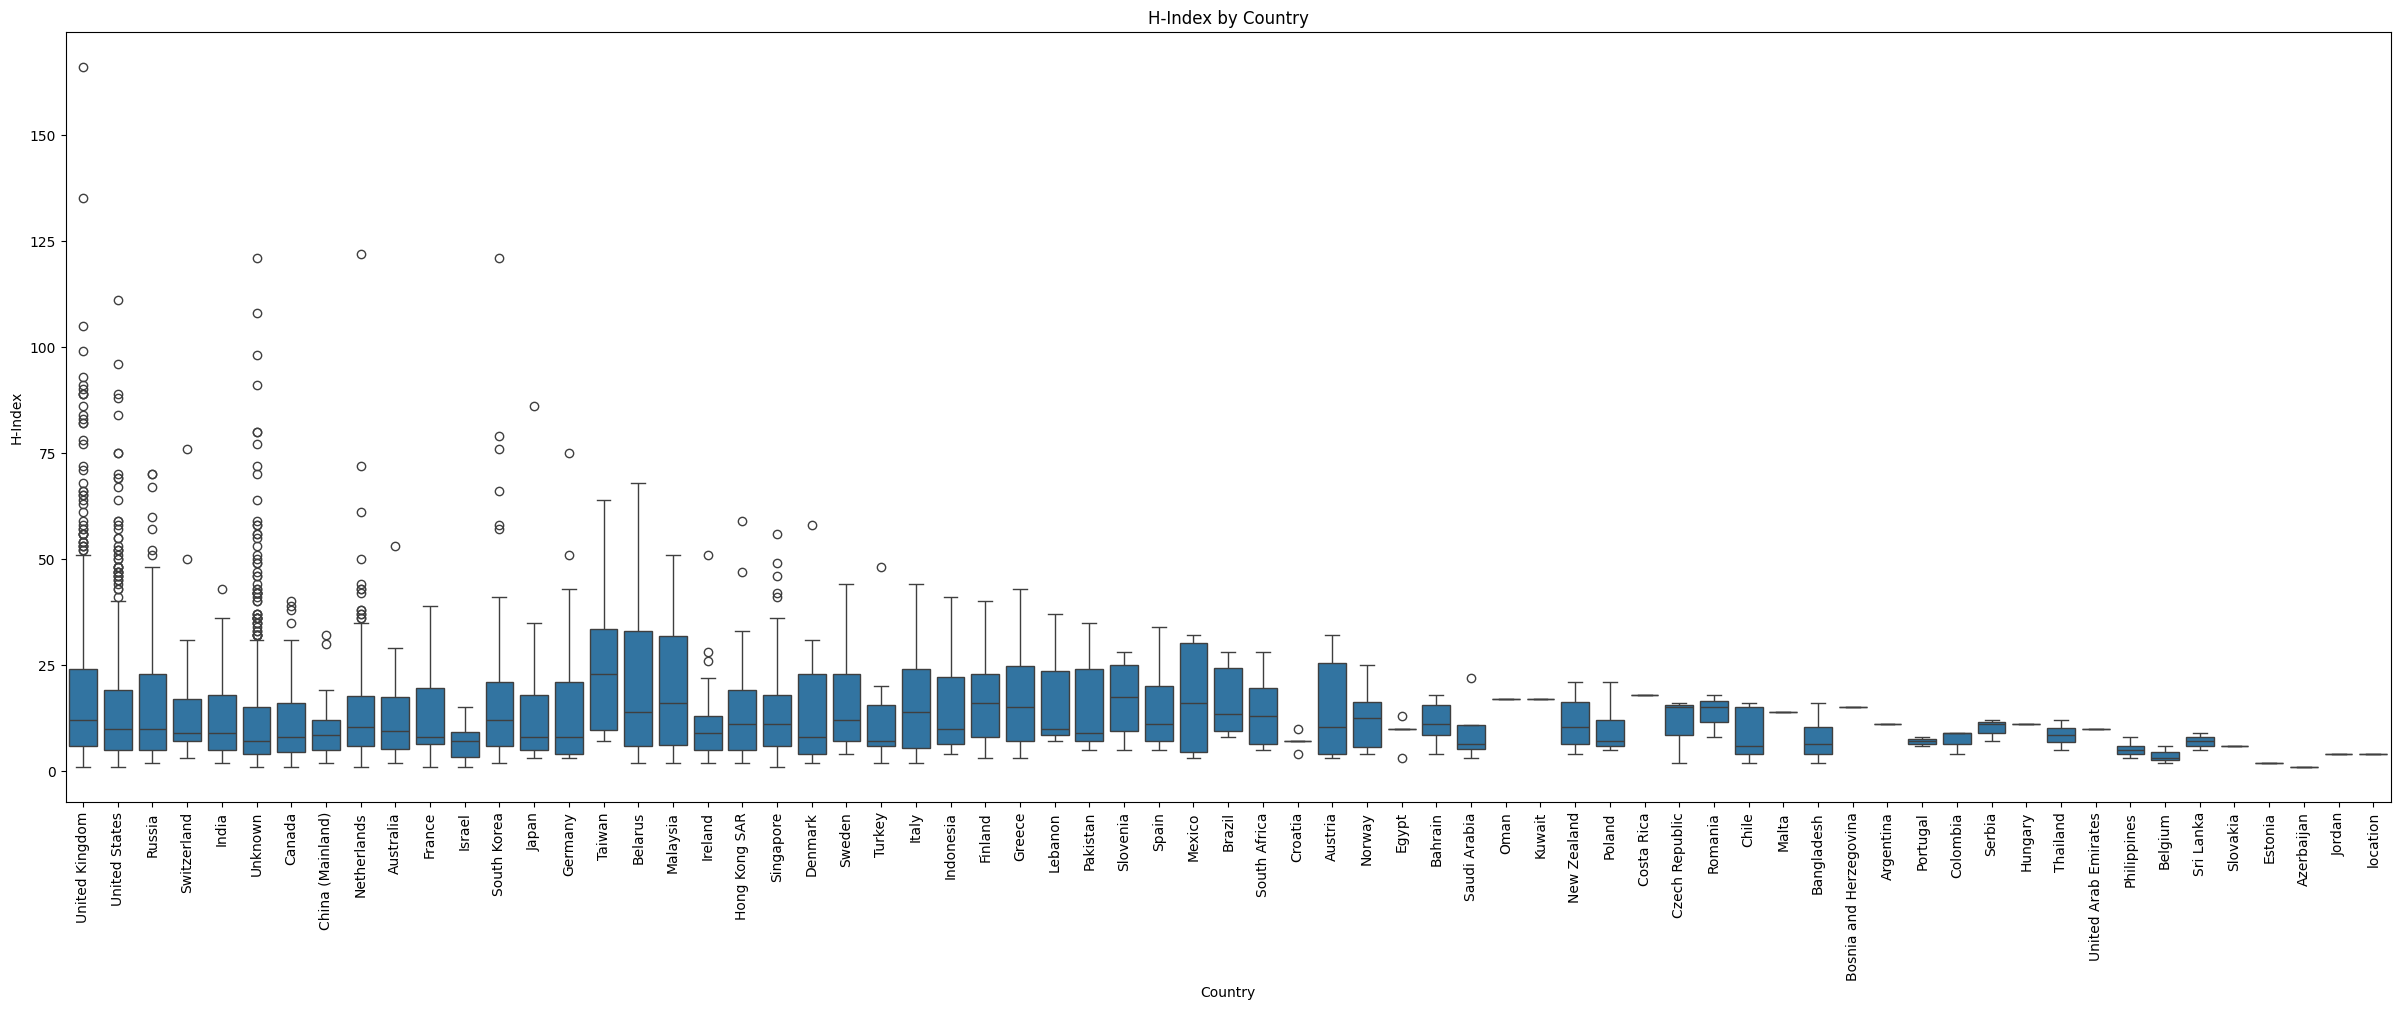

In [99]:
# Create a boxplot of H-index by country
plt.figure(figsize=(30, 10))
sns.boxplot(x="country", y="H-index", data=scholars)
plt.xlabel("Country")
plt.ylabel("H-Index")
plt.title("H-Index by Country")
plt.xticks(rotation=90)
plt.show()


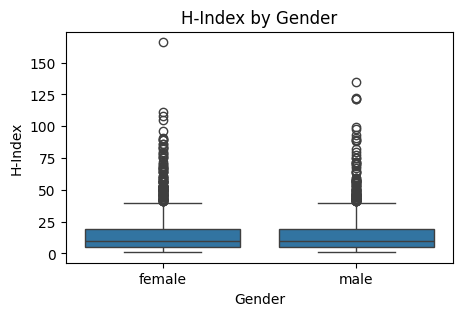

In [101]:
# Create a boxplot of H-index by gender
plt.figure(figsize=(5, 3))
sns.boxplot(x="gender", y="H-index", data=scholars)
plt.xlabel("Gender")
plt.ylabel("H-Index")
plt.title("H-Index by Gender")
plt.show()

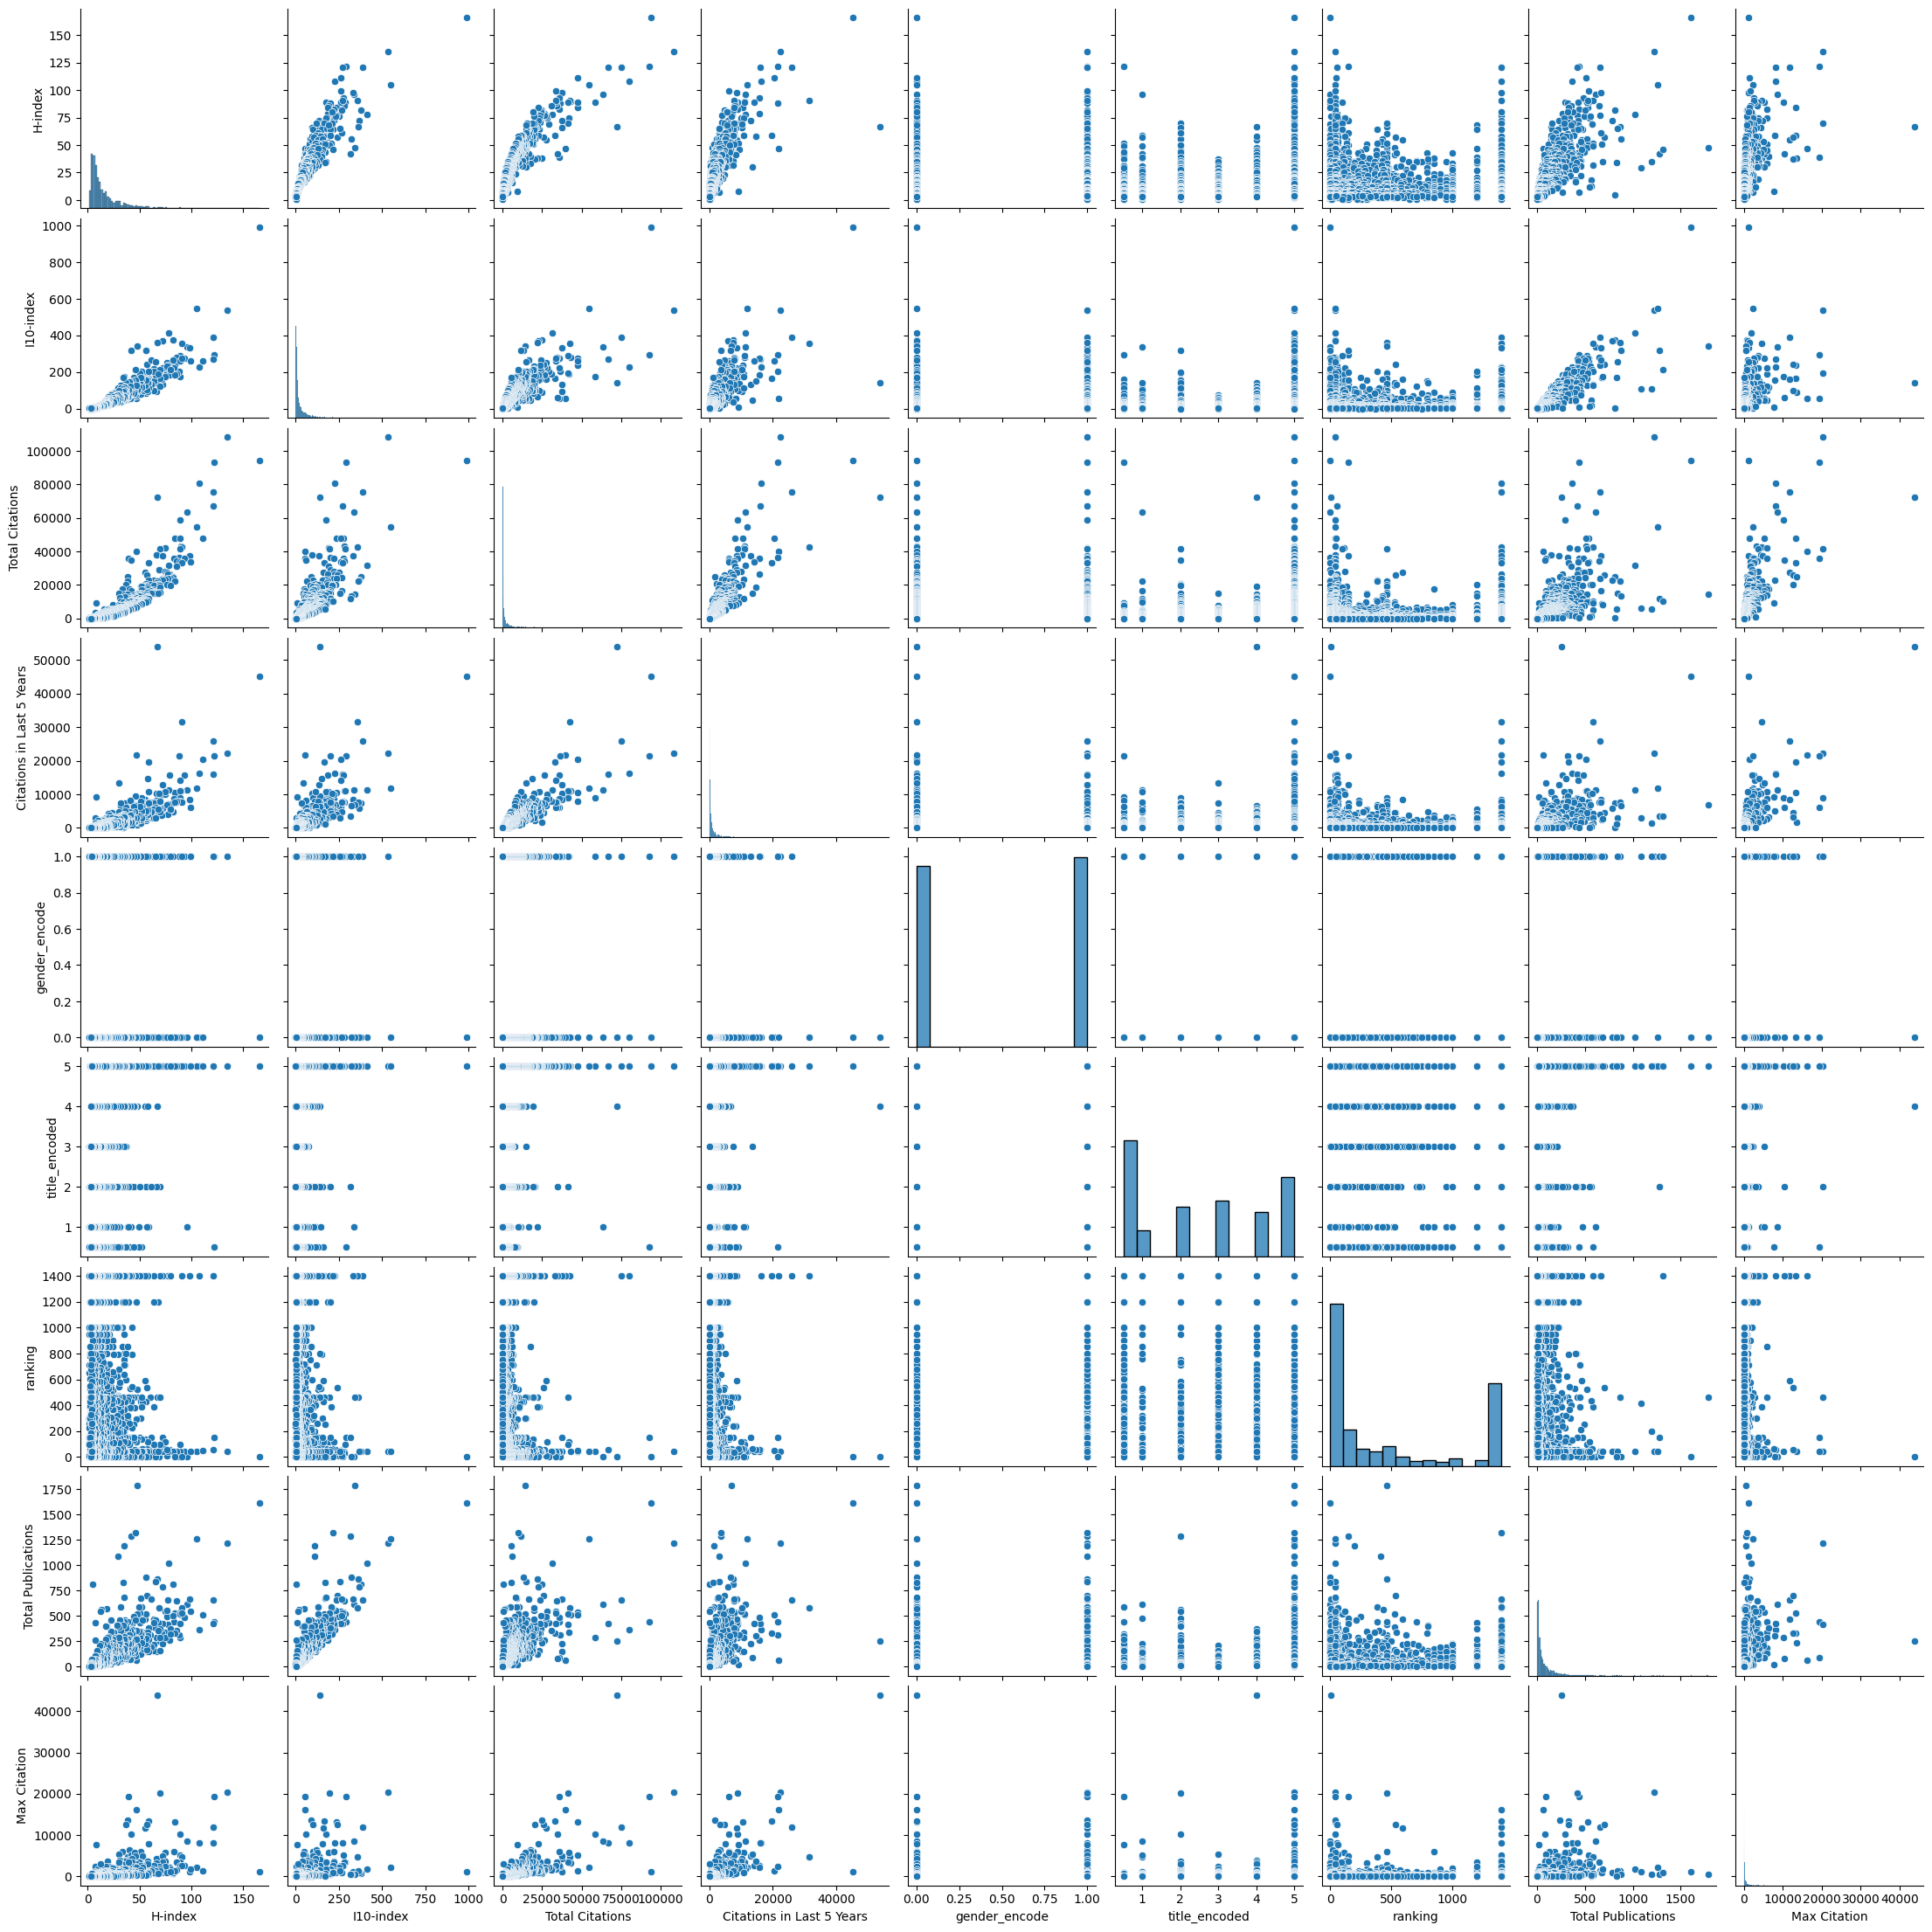

In [102]:
# Get the numeric columns
numeric_columns = scholars.select_dtypes(include=["int", "float"]).columns

# Create a pairplot of the numeric columns
sns.pairplot(scholars[numeric_columns])
plt.show()

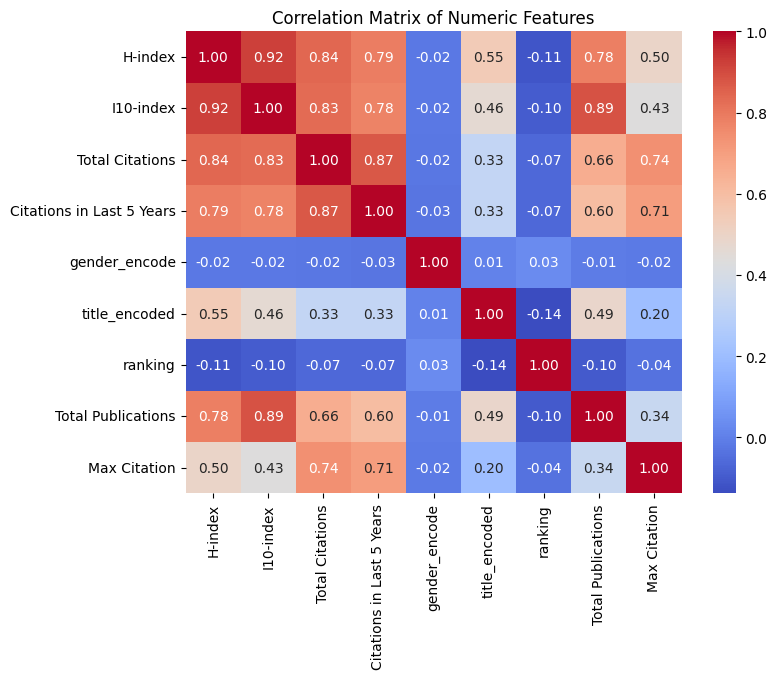

In [92]:
# prompt: plot correlation maxtrix between each numeric features

import matplotlib.pyplot as plt
import seaborn as sns

# Get the numeric columns
numeric_columns = scholars.select_dtypes(include=["int", "float"]).columns

# Create a correlation matrix
correlation_matrix = scholars[numeric_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()